<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Bridge_Cracks/Bridge_Cracks_Detection_Using_TL_3_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**How to use it in Colab:**

1. Run Cells 1–4 once to prepare your environment and datasets.

2. Run Cell 5, 6, 7 separately for each model.

3. Run Cells 8–9 after training a model to generate editable figures and save them.

**Cell 1: Mount Google Drive & Imports**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

AUTOTUNE = tf.data.AUTOTUNE


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os

**Cell 2: Dataset Preparation**

In [11]:
# Dataset path
dataset_dir = '/content/drive/MyDrive/Bridge_Cracks'

# Classes
class_names = sorted(os.listdir(dataset_dir))
class_to_label = {name: idx for idx, name in enumerate(class_names)}
num_classes = len(class_names)
print("Classes:", class_names)

# Collect image paths and labels
image_paths, labels = [], []
for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    for fname in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, fname))
        labels.append(class_to_label[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

# Fixed image size
IMG_HEIGHT, IMG_WIDTH = 224, 224
print("Image size:", IMG_HEIGHT, "x", IMG_WIDTH)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)


Classes: ['Negative', 'Positive']
Image size: 224 x 224


**Cell 3: Data Augmentation & Dataset Loader**

In [12]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Dataset loader
def load_dataset(paths, labels, training=True, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def process(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(process, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1000)

    return ds.batch(batch_size).prefetch(AUTOTUNE)

# Load datasets
train_ds = load_dataset(X_train, y_train, training=True)
test_ds  = load_dataset(X_test, y_test, training=False)


**Cell 4: Model Builder**

In [13]:
def build_model(base_model_fn):
    base_model = base_model_fn(weights='imagenet', include_top=False,
                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


**Cell 5: Train EfficientNetB0**

In [ ]:
model_name = "EfficientNetB0"
model_fn = EfficientNetB0

print(f"Training {model_name}")
model = build_model(model_fn)

EPOCHS = 10
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

# Save model
model.save(f"/content/drive/MyDrive/{model_name}_bridge_cracks.h5")


**Cell 6: Train ResNet50**

In [14]:
model_name = "ResNet50"
model_fn = ResNet50

print(f"Training {model_name}")
model = build_model(model_fn)

EPOCHS = 10
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

# Save model
model.save(f"/content/drive/MyDrive/{model_name}_bridge_cracks.h5")


Training ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2116s 21s/step - accuracy: 0.8708 - loss: 0.3501 - val_accuracy: 0.2707 - val_loss: 17.3302
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2044s 21s/step - accuracy: 0.9789 - loss: 0.0702 - val_accuracy: 0.2707 - val_loss: 19.8231
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1953s 20s/step - accuracy: 0.9838 - loss: 0.0495 - val_accuracy: 0.2707 - val_loss: 25.6783
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1973s 21s/step - accuracy: 0.9894 - loss: 0.0354 - val_accuracy: 0.2694 - val_loss: 15.6170
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2017s 21s/step - accuracy: 0.9862 - loss: 0.0487 - val_accuracy: 0.4363 - val_loss: 0.8655
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2035s 21s/step - accuracy: 0.9911 - loss: 0.0370 - val_accuracy: 0.8147 - val_loss: 0.5300
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2055s 21s/step - accuracy: 0.9850 - loss: 0.0497 - val_accuracy: 0.6334 - val_loss: 0.7971
Epoch 8/10
95/95 ━━━━━━━

**Cell 7: Train MobileNetV2**

In [ ]:
model_name = "MobileNetV2"
model_fn = MobileNetV2

print(f"Training {model_name}")
model = build_model(model_fn)

EPOCHS = 10
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

# Save model
model.save(f"/content/drive/MyDrive/{model_name}_bridge_cracks.h5")


**Cell 8: Plot Confusion Matrices**

In [ ]:
# Predictions
y_train_true = np.concatenate([y for x, y in train_ds], axis=0)
y_test_true  = np.concatenate([y for x, y in test_ds], axis=0)

y_train_prob = model.predict(train_ds)
y_test_prob  = model.predict(test_ds)

y_train_pred = np.argmax(y_train_prob, axis=1)
y_test_pred  = np.argmax(y_test_prob, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_test  = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"{model_name} – Training CM")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1,2,2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"{model_name} – Testing CM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save figure
plt.savefig(f"/content/drive/MyDrive/{model_name}_confusion_matrix.png")


**Cell 9: Plot ROC Curve**

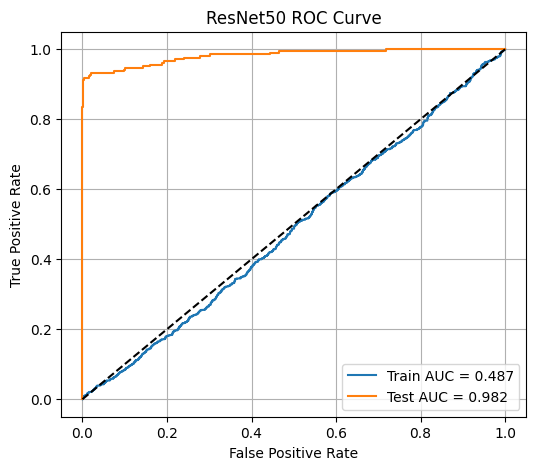

<Figure size 640x480 with 0 Axes>

In [16]:
fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_prob[:,1])
fpr_test,  tpr_test,  _ = roc_curve(y_test_true,  y_test_prob[:,1])

auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

plt.figure(figsize=(6,5))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
plt.plot(fpr_test,  tpr_test,  label=f"Test AUC = {auc_test:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{model_name} ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Save figure
plt.savefig(f"/content/drive/MyDrive/{model_name}_roc_curve.png")


In [17]:
# Number of training images
num_train = X_train.shape[0]  # first dimension is the number of samples
print("Number of training images:", num_train)

# Number of testing images
num_test = X_test.shape[0]
print("Number of testing images:", num_test)


Number of training images: 3040
Number of testing images: 761


In [20]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def calculate_metrics_df(y_true, y_pred):
    # Convert one-hot labels to class indices if needed
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true_classes = np.argmax(y_true, axis=1)
    else:
        y_true_classes = y_true

    y_pred_classes = y_pred

    # Compute metrics
    metrics = {
        "Accuracy": accuracy_score(y_true_classes, y_pred_classes),
        "Precision": precision_score(y_true_classes, y_pred_classes, average='weighted'),
        "Recall": recall_score(y_true_classes, y_pred_classes, average='weighted'),
        "F1-score": f1_score(y_true_classes, y_pred_classes, average='weighted')
    }
    return metrics

# Calculate metrics for training and testing sets
train_metrics = calculate_metrics_df(y_train_true, y_train_pred)
test_metrics = calculate_metrics_df(y_test_true, y_test_pred)

# Combine into a DataFrame
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["Training Set", "Testing Set"])
metrics_df


,Accuracy,Precision,Recall,F1-score
Training Set,0.643421,0.598127,0.643421,0.615987
Testing Set,0.954008,0.956736,0.954008,0.952576


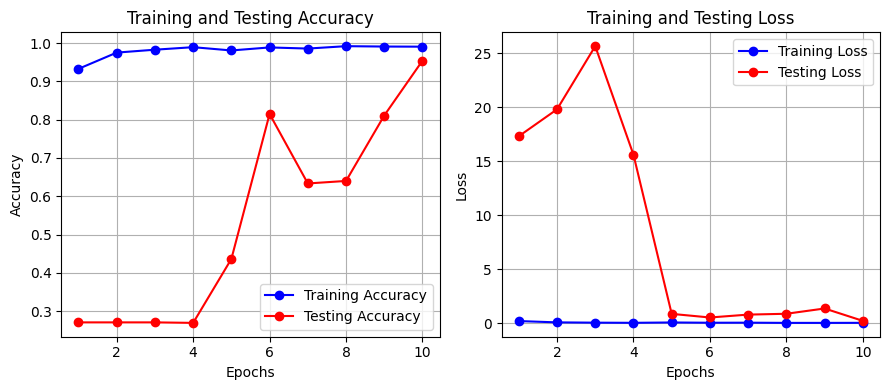

In [23]:
import matplotlib.pyplot as plt

# Example: model.fit(...) returns a history object
# history = model.fit(train_ds, validation_data=test_ds, epochs=..., ...)

# Extract metrics from history
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, test_acc, 'r-o', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, test_loss, 'r-o', label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
